In [6]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.manifold import TSNE
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from collections import Counter

client = Client(processes=False)
df = dd.read_csv("../data/raw/Eluvio_DS_Challenge.csv", blocksize=64000000)
df.time_created = df.time_created.astype('uint32')
df.up_votes = df.up_votes.astype('uint16')
df.down_votes = df.down_votes.astype('uint16')

df = client.persist(df)
print df.dtypes;
MODEL_TYPES = {
    'LDA': LatentDirichletAllocation,
    'LSA': TruncatedSVD
}
TOPIC_COLOR_MAP = np.array([
    "#1f77b5", "#aec7e9", "#ff7f0f", "#ffbb79", "#2ca02d", "#98df8b", "#d62729", "#ff9897", "#9467be", "#c5b0d6",
    "#8c564c", "#c49c95", "#e377c3", "#f7b6d3", "#7f7f80", "#c7c7c8", "#bcbd23", "#dbdb8e", "#17bed0", "#9edae6"
])
count_vectorizer_limited = CountVectorizer(stop_words='english', max_features=40000)

class Topic_Model:
    def __init__(self, input_df, model_type='LDA',max_features=None, **args):
        self.df = input_df
        self.n_components = args['n_components'] if 'n_components' in args else 0
        self.sampled_df = self.df.sample(frac=0.05)
        self.sampled_titles = self.sampled_df['title'].compute().values
        self.sampled_up_votes = self.sampled_df['up_votes'].compute().values
        self.sampled_document_term_matrix = count_vectorizer_limited.fit_transform(self.sampled_titles)
        
        self.model_type = model_type
        if model_type.upper() not in MODEL_TYPES.keys():
            self.model_type = MODEL_TYPES.keys()[0]
        model_func = MODEL_TYPES[self.model_type]
        print "initialing & fitting {} model...".format(self.model_type)
        self.model = model_func(**args)
        self.topic_matrix = self.model.fit_transform(self.sampled_document_term_matrix)
        
        print "generating categories..."
        self.keys = self._get_keys(self.topic_matrix)
        self.categories, self.counts = self._keys_to_counts(self.keys)
        
    
    def _get_keys(self, topic_matrix):
        keys = topic_matrix.argmax(axis=1).tolist()
        return keys
    
    def _keys_to_counts(self, keys):
        count_pairs = Counter(keys).items()
        categories = [pair[0] for pair in count_pairs]
        counts = [pair[1] for pair in count_pairs]
        return (categories, counts)
    
    def _get_top_n_words(self, n, keys, count_vectorizer):
        top_word_indices = []
        for topic in range(self.n_components):
            temp_vector_sum = 0
            for i in range(len(keys)):
                if keys[i] == topic:
                    temp_vector_sum += self.sampled_document_term_matrix[i]
            temp_vector_sum = temp_vector_sum.toarray()
            top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
            top_word_indices.append(top_n_word_indices)   
        top_words = []
        for topic in top_word_indices:
            topic_words = []
            for index in topic:
                temp_word_vector = np.zeros((1, self.sampled_document_term_matrix.shape[1]))
                temp_word_vector[:,index] = 1
                the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
                topic_words.append(the_word.encode('ascii').decode('utf-8'))
            top_words.append(" ".join(topic_words)) 
        return top_words
    
    def get_top_n_topics(self, count_vectorizer, n=10):
        top_n_words = self._get_top_n_words(n, self.keys, count_vectorizer)
        print "top {} words for each topic by {}:".format(n, self.model_type)
        for idx, topic in enumerate(top_n_words):
            print("Topic {}: ".format(idx + 1), topic)

    
    def plot_num_title_of_each_topic(self, count_vectorizer):
        top_3_words = self._get_top_n_words(3, self.keys, count_vectorizer)
        print "self.categories:{}".format(self.categories)
        print "top_3_words:{}".format(top_3_words)
        labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in self.categories]
        fig, ax = plt.subplots(figsize=(16,8))
        print "Frequency of the {} topics by {}:".format(self.n_components, self.model_type)
        ax.bar(self.categories, self.counts)
        ax.set_xticks(self.categories)
        plt.xticks(rotation=45)
        ax.set_xticklabels(labels)
        ax.set_ylabel('Number of titles')
        ax.set_title('{} topic frequency'.format(self.model_type))
        plt.show()
        
    def _get_mean_topic_vectors(self, keys, two_dim_vectors):
        '''
        returns a list of centroid vectors from each predicted topic category
        '''
        centroid_topic_vectors = []
        for t in range(self.n_components):
            articles_in_that_topic = []
            for i in range(len(keys)):
                if keys[i] == t:
                    articles_in_that_topic.append(two_dim_vectors[i])    

            articles_in_that_topic = np.vstack(articles_in_that_topic)
            centroid_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
            centroid_topic_vectors.append(centroid_article_in_that_topic)
        return centroid_topic_vectors
    
    def visualize_tnse_2_dimension(self, count_vectorizer):
        print "use t-SNE to visualize {} high dimensional dataset".format(self.model_type)
        tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
        tsne_vectors = tsne_model.fit_transform(self.topic_matrix)
        mean_topic_vectors = self._get_mean_topic_vectors(self.keys, tsne_vectors)
        
        colormap = TOPIC_COLOR_MAP[:self.n_components]
        proportion = 20;
        sampled_up_votes_sizes = self.sampled_up_votes / proportion;
        top_3_words = self._get_top_n_words(3, self.keys, count_vectorizer)
        fig, ax = plt.subplots(figsize=(16,16))
        plt.scatter(x=tsne_vectors[:,0], y=tsne_vectors[:,1],
                    color=colormap[self.keys],
                    marker='o', s=sampled_up_votes_sizes, alpha=0.5)
        for t in range(self.n_components):
            plt.text(mean_topic_vectors[t][0],
                     mean_topic_vectors[t][1],
                     top_3_words[t], color=colormap[t],
                     horizontalalignment='center', weight='bold')
        plt.show()

time_created    uint32
date_created    object
up_votes        uint16
down_votes      uint16
title           object
over_18           bool
author          object
category        object
dtype: object


determining the number of topics
coherence scores: [0.22110439437678941, 0.215714160812571, 0.21976571862213293, 0.21467840352892517, 0.24003214057743802, 0.23541620019994464, 0.21978638952175175, 0.22950279463725298, 0.24805891308401798, 0.24116856133971326, 0.26465971594624077, 0.2603934137355023, 0.26723328552382575, 0.255706962656159, 0.24272760856839287, 0.24741445205866763, 0.2509184591324871, 0.26693777124688, 0.26368363044325893, 0.2597937731769392, 0.2458465363419948, 0.24641989346649848, 0.2483632561562407, 0.25620471716547344, 0.2510313242405812, 0.255216167105509, 0.24540848191501838, 0.2400735802881247, 0.25324517163542876, 0.23639801993101708, 0.25129780834796706, 0.24504294536020915, 0.24077043787276395, 0.25415869345506914, 0.2517407955996738, 0.24788068978530783, 0.23337680295753263, 0.2433663687538018, 0.2415350662859132, 0.24764831710382332, 0.24441442846420708, 0.25279932983028436, 0.24442338632484475, 0.24494400116279427, 0.2500194465481946, 0.23747109729055862, 0.

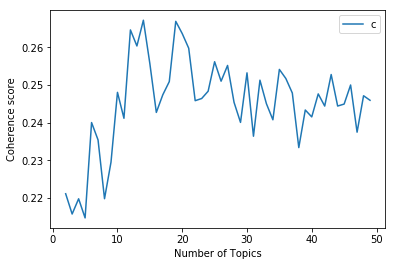

In [20]:
print "determining the number of topics"
count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
sampled_df = df.sample(frac=0.1)
sampled_titles = sampled_df['title'].compute().values
sampled_up_votes = sampled_df['up_votes'].compute().values

sampled_document_term_matrix = count_vectorizer.fit_transform(sampled_titles)
def tokenize_titles(titles):

    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    texts = []
    for title in titles:
        raw = title.decode('utf-8').strip().lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [token for token in tokens if not token in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        texts.append(stemmed_tokens)
    return texts

words = tokenize_titles(sampled_titles)
dictionary = corpora.Dictionary(words)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in words]
def compute_plot_coherence_values(doc_term_matrix, stop, start=2, step=1):

    coherence_values = []
    model_list = []
    num_options = range(start, stop, step)
    for num_topics in num_options:
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=words, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    print "coherence scores: {}".format(coherence_values)
    print "plotting coherence score for different number of topics" 
    plt.plot(num_options, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence scores"), loc='best')
    plt.show()

compute_plot_coherence_values(doc_term_matrix, 50, 2, 1)

In [21]:
print "setting num of topics to be 14"
n_topics = 14
lsa_model = Topic_Model(sampled_df, model_type='LSA', max_features=40000, n_components=n_topics)
lsa_model.get_top_n_topics(count_vectorizer_limited, 10)

setting num of topics to be 14
initialing & fitting LSA model...
generating categories...
top 10 words for each topic by LSA:
('Topic 1: ', u'china state attack islamic killed india said pakistan president chinese')
('Topic 2: ', u'china sea south japan population chinese economy 10 human labor')
('Topic 3: ', u'says india agency isis russia syria minister british venezuela ukraine')
('Topic 4: ', u'korea north south korean africa missile nuclear launch kim test')
('Topic 5: ', u'iran nuclear israel deal sanctions obama talks program tehran germany')
('Topic 6: ', u'new says land case world york just uk porn jerusalem')
('Topic 7: ', u'russia ukraine nato syria arctic russian crimea crisis new ukrainian')
('Topic 8: ', u'world climate million global change biggest save 000 economy cup')
('Topic 9: ', u'police death london arrest arrested anti gay protesters latest mps')
('Topic 10: ', u'government minister saudi country prime oil eu anti foreign arabia')
('Topic 11: ', u'israel israeli

initialing & fitting LSA model...
generating categories...
self.categories:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
top_3_words:[u'china says government', u'china sea south', u'korea north south', u'syria al isis', u'police people killed', u'world state islamic', u'new government saudi', u'russia syria ukraine', u'president israeli bank', u'russian germany says', u'israel gaza war', u'iran nuclear deal', u'minister japan prime', u'years 000 year']
Frequency of the 14 topics by LSA:


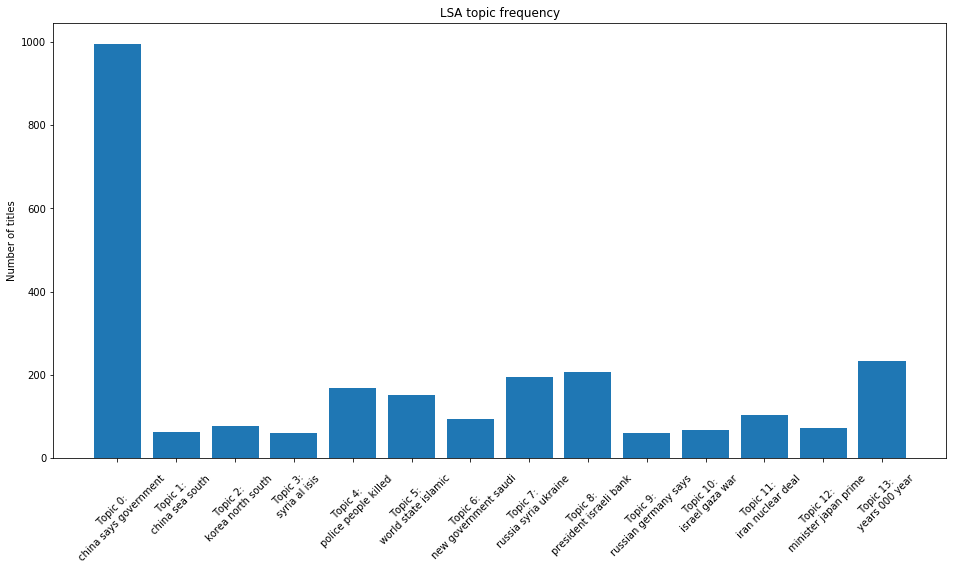

In [22]:
lsa_model = Topic_Model(sampled_df, model_type='LSA', max_features=40000, n_components=14)
lsa_model.plot_num_title_of_each_topic(count_vectorizer_limited)

initialing & fitting LSA model...
generating categories...
use t-SNE to visualize LSA high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2546 samples in 0.002s...
[t-SNE] Computed neighbors for 2546 samples in 0.270s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2546
[t-SNE] Computed conditional probabilities for sample 2000 / 2546
[t-SNE] Computed conditional probabilities for sample 2546 / 2546
[t-SNE] Mean sigma: 0.044946
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.945503
[t-SNE] KL divergence after 2000 iterations: 0.846168


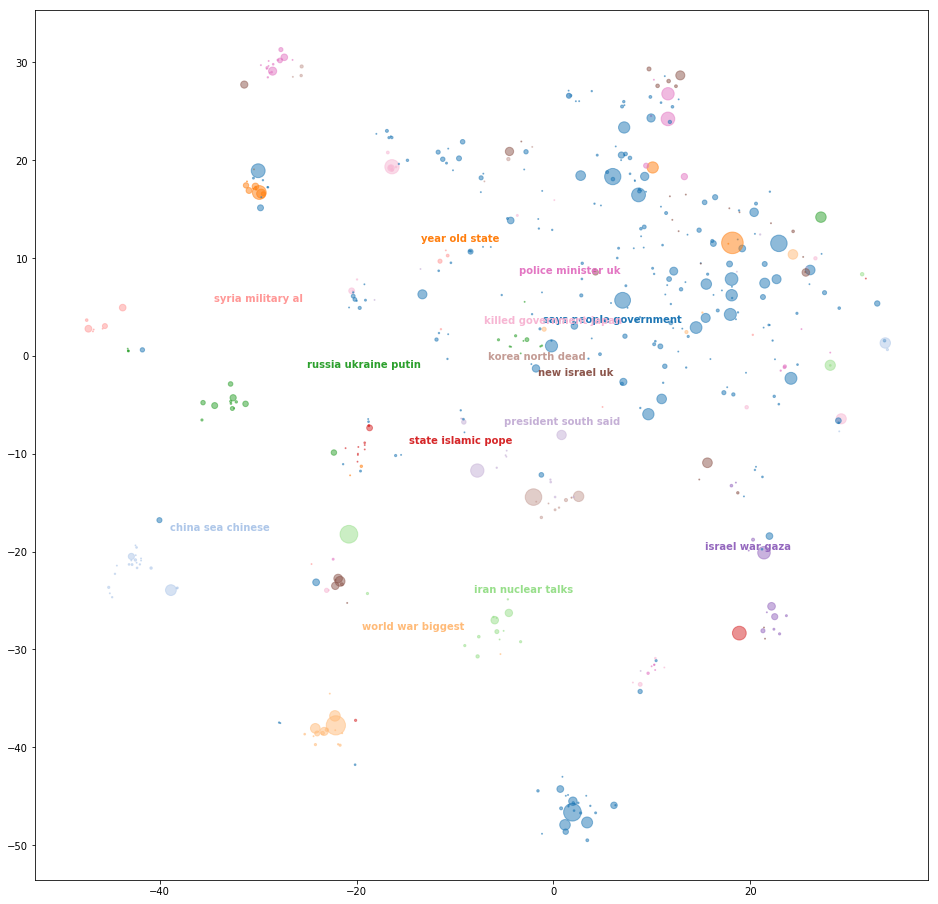

In [23]:
lsa_model = Topic_Model(sampled_df, model_type='LSA', max_features=40000, n_components=14)
lsa_model.visualize_tnse_2_dimension(count_vectorizer_limited)

In [24]:
print "Try LDA"
lda_model = Topic_Model(sampled_df, model_type='LDA', max_features=40000, learning_method='online', n_components=14, random_state=0, verbose=1)
lda_model.get_top_n_topics(count_vectorizer_limited, 10)

Try LDA
initialing & fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
generating categories...
top 10 words for each topic by LDA:
('Topic 1: ', u'court ex women police protest jailed year men muslim month')
('Topic 2: ', u'uk turkey media wants laws end google online social say')
('Topic 3: ', u'killed people israeli dead war syrian police gaza army man')
('Topic 4: ', u'syria russia says ukraine military minister government president russian french')
('Topic 5: ', u'years year greece 000 million new old government people china')
('Topic 6: ', u'iran korea north nuclear israel attack israeli pakistan palestinian south')
('Topic 7: ', u'news state al bbc court death life islamic sex world')
('Topic 8: ', u'brazil case dies catc

initialing & fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
generating categories...
self.categories:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
top_3_words:[u'man 000 israeli', u'japan nuclear india', u'syria rights egypt', u'pope russia russian', u'says world israel', u'war iran group', u'military dead syrian', u'china minister new', u'uk russia french', u'world india officials', u'state isis islamic', u'people killed chinese', u'eu canada says', u'police government north']
Frequency of the 14 topics by LDA:


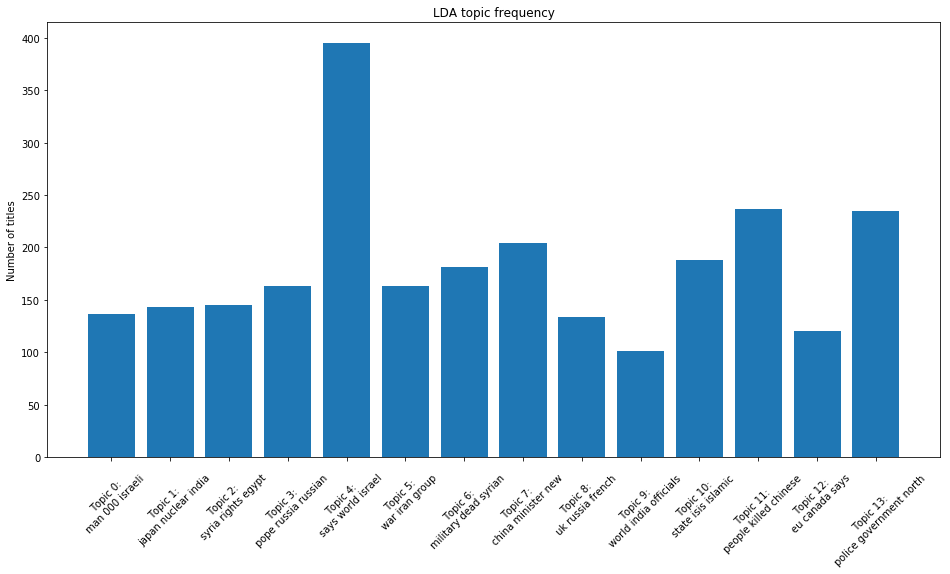

In [25]:
lda_model = Topic_Model(sampled_df, model_type='LDA', max_features=40000, learning_method='online', n_components=14, random_state=0, verbose=1)
lda_model.plot_num_title_of_each_topic(count_vectorizer_limited)

initialing & fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
generating categories...
use t-SNE to visualize LDA high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2546 samples in 0.001s...
[t-SNE] Computed neighbors for 2546 samples in 0.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2546
[t-SNE] Computed conditional probabilities for sample 2000 / 2546
[t-SNE] Computed conditional probabilities for sample 2546 / 2546
[t-SNE] Mean sigma: 0.152958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.757523
[t-SNE] KL divergence after 2000 iterations: 0.955153


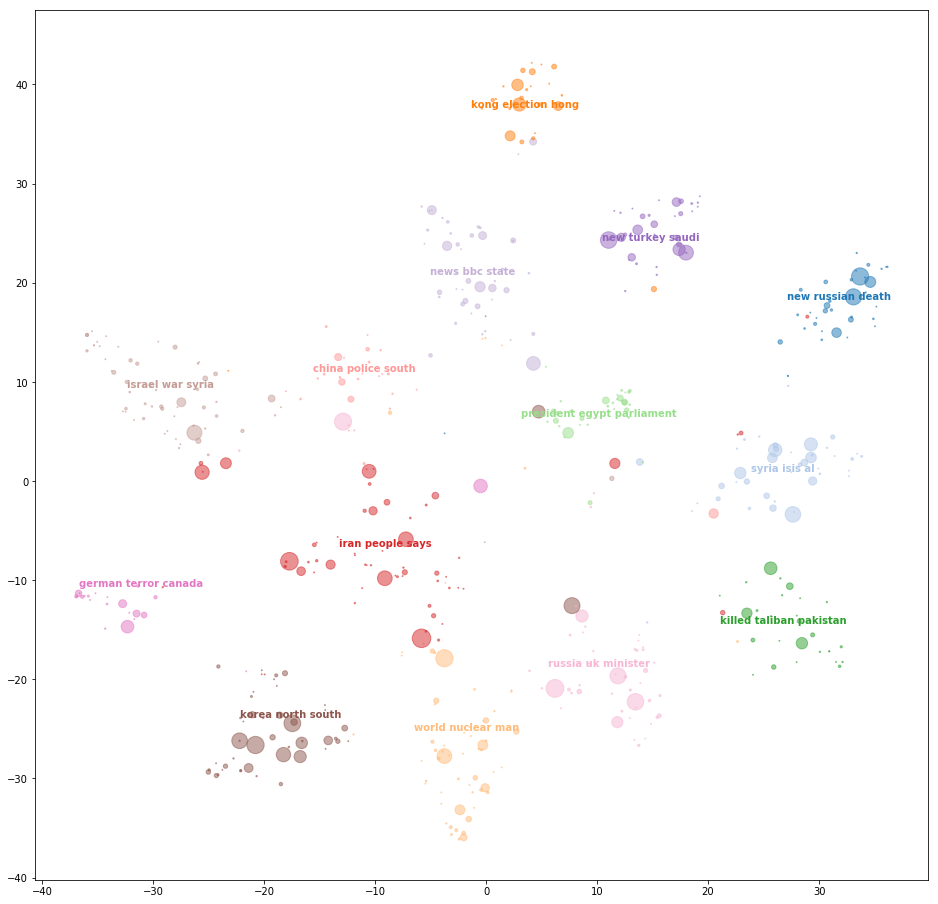

In [26]:
lda_model = Topic_Model(sampled_df, model_type='LDA', max_features=40000, learning_method='online', n_components=14, random_state=0, verbose=1)
lda_model.visualize_tnse_2_dimension(count_vectorizer_limited)

Scale up to the entire dataset
lazy loading dataset...
initializing LDA model...
initialing & fitting LDA model...
iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
generating categories...
use t-SNE to visualize LDA high dimensional dataset
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 25462 samples in 0.014s...
[t-SNE] Computed neighbors for 25462 samples in 16.906s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25462
[t-SNE] Computed conditional probabilities for sample 2000 / 25462
[t-SNE] Computed conditional probabilities for sample 3000 / 25462
[t-SNE] Computed conditional probabilities for sample 4000 / 25462
[t-SNE] Computed conditional probabilities for sample 5000 / 25462
[t-SNE] Computed conditional probabil

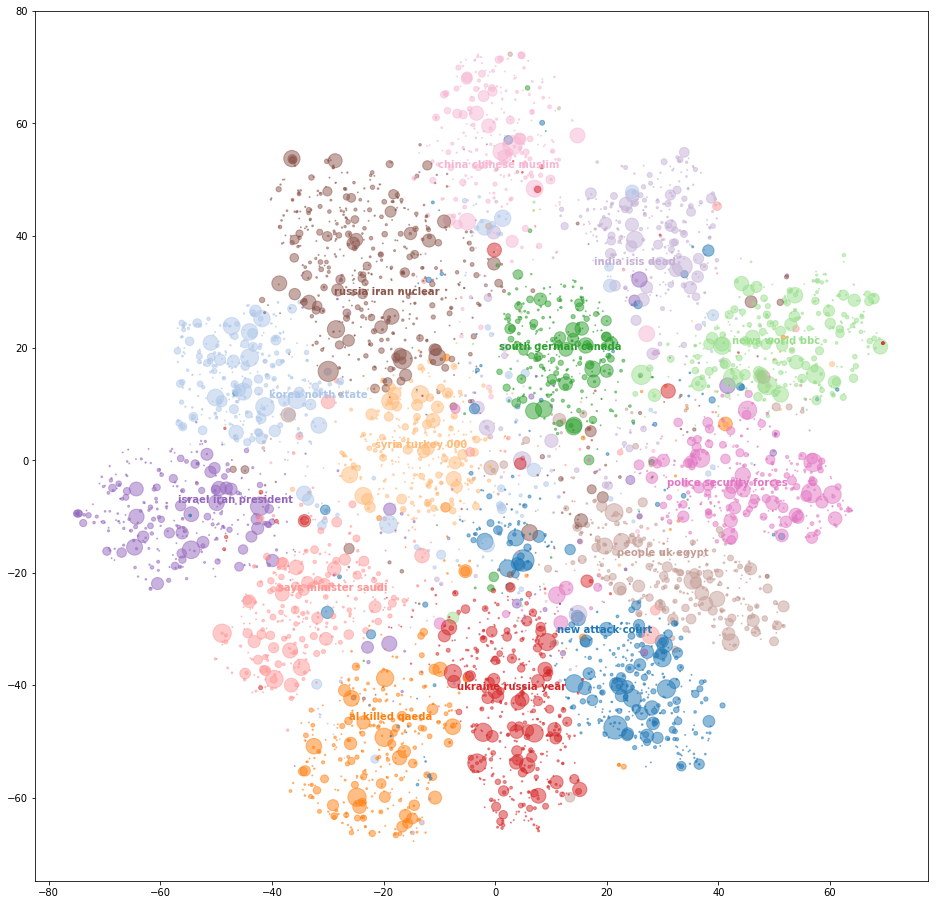

In [12]:
print "Scale up to the entire dataset"
print "lazy loading dataset..."
entire_df = df
entire_titles = entire_df['title'].compute().values
entire_up_votes = entire_df['up_votes'].compute().values
print "initializing LDA model..."
entire_lda_model = Topic_Model(entire_df, model_type='LDA', max_features=40000, learning_method='online', n_components=14, random_state=0, verbose=1)
entire_lda_model.visualize_tnse_2_dimension(count_vectorizer_limited)